# Practicing Feedback Control

In this unit we are going to explore basic feedback control on a highly simplified, 1-dimensional model of the quadrotor-camera system.

## Simple Slide Camera

Imagine a camera attached to a cart that is allowed to slide along a 1-dimensional track. The track is elevated some height $h$ above the ground and the camera is pointing downward. There is some target on the ground that the camera can observe; more specifically the camera can measure the angle $-\pi /2 < \gamma < \pi/2$ from the centerline of the camera to the target. The objective is to issue velocity commands, $v_{cmd}$, in order to move the cart to a position such that $\gamma \rightarrow \gamma_{des}$ (e.g. if $\gamma_{des} = 0$, then the objective is simply to move the cart directly over the target.

This system is depicted in the below diagram:

<img src="files/simple_slide_camera.jpg">

This somewhat contrived system can be thought of as a highly simplified model of the quadrotor and it's downward-facing camera. If the quadrotor is constrained to move in one dimension, can be controlled via velocity commands, and we ignore the pitch that is induced when changing velocity (valid assumption for low-acceleration maneuvers), then we can roughly model the quadrotor as this simple slide camera

Note that the position of the cart, $x$, and position of the target $x_{des}$ are not directly measured, only $\gamma$ is measured.

Now we will provide the code necessary to simulate this system

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

_HEIGHT = 1.0
_VEL_CONST = 1.0
_TIME_STEP = 0.1

## Plant Dynamics, Sensors, and Actuators

the following object contains functions for the plant dynamics, sensing of the target angle $\gamma$, and actuator for $v_{cmd}$

In [17]:
class SimpleSlideCamera():
    '''Object that defines the dynamics of the simple slide-camera'''

    def __init__(self, x_0, v_0, x_d, gamma_d=0.0, h=_HEIGHT):

        # state variables (hidden)
        self.__x = x_0
        self.__v = v_0

        # reference position (hidden)
        self.__x_d = x_d

        # reference angle (observed)
        self.gamma_d = gamma_d

        # parameters
        self.__h = h

    def sense_gamma(self):
        # calculate angle from camera center line to target
        return  np.arctan2(self.__x - self.__x_d, self.__h)

    def _get_hidden_position(self):

        return self.__x

    def _get_hidden_position_desired(self):
        return self.__x_d

    def _get_hidden_velocity(self):
        return self.__v

    def actuate_velocity_command(self, vel_cmd, dt=_TIME_STEP):
        self.__v = vel_cmd
        self.__x += self.__v*dt

    def actuate_disturbed_velocity_command(self, vel_cmd, dt=_TIME_STEP, vel_bias=0.5, vel_std=0.1):
        self.__v = vel_cmd + np.random.normal(vel_bias, vel_std)
        self.__x += self.__v*dt

    def actuate_acceleration_command(self, acc_cmd, dt=_TIME_STEP):
        self.__v += acc_cmd*dt
        self.__x += self.__v*dt

## Controller

In [18]:
def p_control(y_err, kp):
    """Proportional control law.

    Parameters
    ----------
    y_err : float
        Error signal y_des - y.
    kp : float
        Proportional gain.

    Returns
    -------
    cmd : float
        Control command (e.g. velocity).
    """
    # Proportional term
    cmd = kp * y_err
    return cmd


In [19]:
# p_control tests
assert np.isclose(p_control(0.0, 1.0), 0.0)
assert np.isclose(p_control(1.0, 1.0), 1.0)
assert np.isclose(p_control(-10.0, 0.1), -1.0)

## Simulation Script

below is a script for testing various controllers for the `SimpleSlideCamera` plant as well as plotting the results.

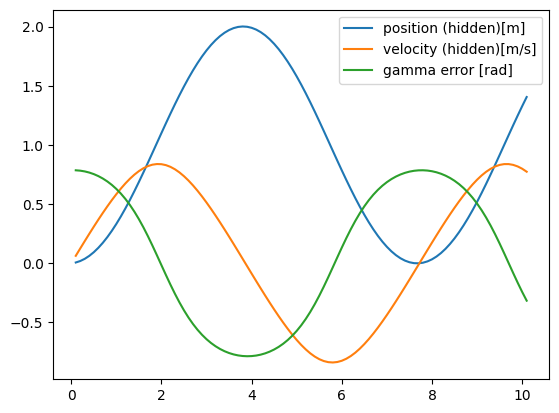

In [20]:
# Proportional gain
kp = 0.8  # tuned by simple trial‑and‑error for quick convergence without overshoot


# Control inputs
dt = _TIME_STEP
t_final = 10.0

# intial conditions (position, velocity and target position)
x_0 = 0.0
v_0 = 0.0
x_des = 1.0

# create SimpleSlideCamera with initial conditions
sscam = SimpleSlideCamera(x_0, v_0, x_des)

# initialize data storage
data = dict()
data['t'] = []
data['acc_cmd'] = []
data['vel_cmd'] = []
data['err_gamma'] = []
data['x_hidden'] = []
data['v_hidden'] = []
t = 0.0
err_prev = 0.0
while t < t_final:
    t += dt

    # ADD SENSOR: sense output variable gamma (angle from camera centerline to target) and calculate error from desired
    err_gamma 
    
    # ADD CONTROLLER: call velocity control algoritm
    vel_cmd  

    # ACTUATOR: send velocity command to plant
    sscam.actuate_velocity_command(vel_cmd)

    # store data
    err_gamma_prev = err_gamma
    data['t'].append(t)
    data['vel_cmd'].append(vel_cmd)
    data['err_gamma'].append(err_gamma)
    data['x_hidden'].append(sscam._get_hidden_position())
    data['v_hidden'].append(sscam._get_hidden_velocity())

# Plot Data
handle_position, = plt.plot(data['t'], data['x_hidden'], label='position (hidden)[m]')
handle_velocity, = plt.plot(data['t'], data['v_hidden'], label='velocity (hidden)[m/s]')
handle_err_gamma, = plt.plot(data['t'], data['err_gamma'], label='gamma error [rad]')
plt.legend(handles=[handle_position, handle_velocity, handle_err_gamma])
plt.show()

## Questions

__Q1.__ Does your gamma error (i.e. output converge to 0.0?
    - If so how quickly (i.e. how long does it take for the error to be 5% of the original error)
    - If not, what is happening? Is the error never changing or is it oscillating back and forth across zero? Can you change the proportional gain kp to change this behavior?


ANSWER HERE

__Q2.__ What values should your system's position and velocity be converging upon? Since this is a practice problem and we want to gain understanding of how this system behaves, we've cheated and let you observe the position and velocity of the system which were meant to be unobservable in the real world. Are the position and velocity converging to values you expected?


ANSWER HERE

__Q3.__ As you increase the proportional gain, what happens to the rate at which the error converges to zero?

Can you find a proportional gain that converges within 1 second (i.e error reaches 5% of it's original value)? Note: if you start to see an oscillatory, saw-tooth pattern, you're gain is too high.


ANSWER HERE

__Q4.__ What happens if you cannot perfectly control the velocity, for example there is some form of velocity disturbance that you cannot control (e.g. wind, actuator noise)? Let's try it out:

In the #ACTUATOR portion of the simulation script, replace `actuate_velocity_command` with `actuate_disturbed_velocity_command`, restart the kernel, and run the script. Does output error (gamma error) still converge to zero? If not, what does the gamma error converge to? How might you change your controller to fix this "steady state error"

ANSWER HERE

__Q5.__ Often times we control a system by applying a force. In this way we are not directly controlling the velocity of a system, but instead the acceleration. Let's try it out:

In the ACTUATOR portion of the simulation script replace `actuate_velocity_command` with `actuate_acceleration_command`. In the CONTROLLER portion of the script, have the controller output a acc_cmd instead of vel_cmd (just change the variable name, but this way you know it represents an acceleration instead of a velocity). Restart the kernel and rerun the script

Now what is happening to the gamma error, is it converging to zero? If not, is there anything you could think of to change in you controller in order to converge the error to zero?

ANSWER HERE


# ✈️ Altitude PID for a 1‑D “Quadcopter”

Follow the instructions below to design and tune a PID controller that tracks a two‑segment altitude profile.

Your quadcopter can **only move along the $z$‑axis**.  
Track this reference altitude:

| Time [s] | Desired $z$ [m] |
|:-------:|:---------------:|
| 0 – 5   | **2.0** |
| 5 – 10   | **0.5** |


### 1  Model & dynamics

Continuous equation  

$$ m\ddot z = -mg + T, \qquad T = k_T\,u, \; 0\le u\le 1 $$

Euler step (`plant_step`)  

```python
vz += (-g + k_T*u/m) * dt
z  += vz * dt
```



Below is the base setup for a quadcopter under gravity

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# --- parameters ---------------------------------------------------------
m   = 1.0     # kg
g   = 9.81    # m/s²
k_T = 15.0    # N  (full-throttle thrust)

def plant_step(z, vz, u, dt):
    """Euler integrate 1‑D quad dynamics."""
    acc #ADD: Use equation above
    vz #ADD: Integrate acc
    z  #ADD: Integrate vz
    return z, vz


### 2  PID controller

Once done with coding the simulation loop, return to this cell and tune the different parameters

In [26]:
def pid_control(err, err_int, err_dot, kp, ki, kd):
    """PID with throttle clipping in [0, 1].

    The caller should disable integral accumulation when
    the output saturates (anti‑wind‑up).
    """
    u = kp*err + ki*err_int + kd*err_dot
    return np.clip(u, 0.0, 1.0)

# initial gains (tune! #ADD different numbers rather than 0 0 0)
kp, ki, kd = 0.0, 0.0, 0.0


### 3  Simulation loop

This simulates the drone's height over time, while changing the thrust according to your PID controller

In [28]:
#Variable Setup
dt, t_end = 0.02, 10.0
z = vz = 0.0
err_int = err_prev = 0.0
log_t, log_z, log_vz, log_u, log_err = [], [], [], [], []

# --- main loop ---
t = 0.0
while t < t_end:
    z_des = 2.0 if t < 5.0 else 0.5
    err   #ADD the following
    err_int #Intrgral of error over time
    err_dot  #Derivative of error with respect to time
    u #Use PID controller to define u
    z, vz = plant_step(z, vz, u, dt) #Update simulation

    # log
    log_t.append(t); log_z.append(z); log_vz.append(vz)
    log_u.append(u); log_err.append(err)
    err_prev = err
    t += dt


SyntaxError: invalid syntax (356651712.py, line 14)

### 4  Visualisation

NameError: name 'log_t' is not defined

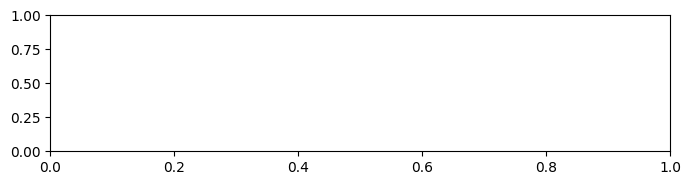

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.subplot(3,1,1); plt.plot(log_t, log_z); plt.ylabel('z [m]')
plt.subplot(3,1,2); plt.plot(log_t, log_vz); plt.ylabel('vz [m/s]')
plt.subplot(3,1,3); plt.plot(log_t, log_u); plt.ylabel('throttle'); plt.xlabel('time [s]')
plt.tight_layout(); plt.show()


# Quadcopter in two dimentions

The math is exactly the same, but now with vectors instead of scalars

Your quadcopter can move only in the X and Y directions at relatively low speeds (it stays flat). Your mission is to catch (be within 10cm of) a ball moving with constant velocity in a windy environement within 15 seconds.

For this final exercise you will be setting up most of the functions. Look back at the 1d situations if you need inspiration or help. A lot of it will be up to you. The wind should be randomly generated with some mean and standard deviation, every timestep it will be different. You should also simulate a ball with its constant velocity and initial position randomly generated. The drone parameters of mass and maximum thrust (in each direction) are already defined.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- parameters ---------------------------------------------------------
m   = 1.0     # kg
k_T = 15.0    # N  (full-throttle thrust)

#Wind vector params (mean & std), used to deterine the randomness

#Velocity of ball, randomely determined

def plant_step(s, v, u, dt, s_ball):
    """Euler integrate 2‑D quad dynamics."""
    #Calculate net force, account for the random variation in the wind
    #Update position of drone, velocity of drone, and position of ball
    return s, v, s_ball


In [ ]:
def pid_control(err, err_int, err_dot, kp, ki, kd):
    """PID with throttle clipping in [0, 1].

    The caller should disable integral accumulation when
    the output saturates (anti‑wind‑up).
    """
    u = kp*err + ki*err_int + kd*err_dot
    return np.clip(u, -1.0, 1.0)
# initial gains (tune!)
kp, ki, kd = 0.0, 0.0, 0.0


In [ ]:
dt, t_max = 0.1, 15.0
#Set up necessary variables
log_s, log_s_ball = [], []#s is position by convention. You may want to add other loggers for debugging
#Randomly place the ball

# --- main loop ---
t = 0.0
while t < t_max:
    #Calculate Errors
    
    #Call pid_control
    
    #Update system with plant_step

    #Append logs. For the append with the format log_s.append(s.copy())

    #Update error

    #Update time
    
    if np.linalg.norm(s_ball-s)<0.1:
        print(f"Time to catch:{t}")
        break

In [ ]:
#this cell is for graphing, don't mess with it unless you want to. If you did it correctly, you should see a 
# graph of the drone and ball's positions over time

log_s = np.array(log_s)
plt.figure(figsize=(8,6))

from matplotlib import cm

log_s = np.array(log_s)
log_s_ball = np.array(log_s_ball)
log_t = np.array(log_t)

t_norm = (log_t - log_t[0]) / (log_t[-1] - log_t[0])

drone_colors = cm.Reds(t_norm)
ball_colors = cm.Blues(t_norm)

plt.figure(figsize=(8, 6))

# Drone with red shades and black edge
plt.scatter(log_s[:, 0], log_s[:, 1], c=drone_colors, s=20, label="Drone", edgecolor='k')

# Ball with blue shades, circle marker, black edge
plt.scatter(log_s_ball[:, 0], log_s_ball[:, 1], c=ball_colors, s=40, marker='o',
            label="Ball", edgecolor='k', linewidth=0.8)

plt.xlabel("X Position [m]")
plt.ylabel("Y Position [m]")
plt.title("2D Trajectory of Drone and Ball Over Time")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()

